In [2]:
import sklearn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Clustering

### K-Means

In [3]:
from sklearn.datasets import make_blobs

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [4]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

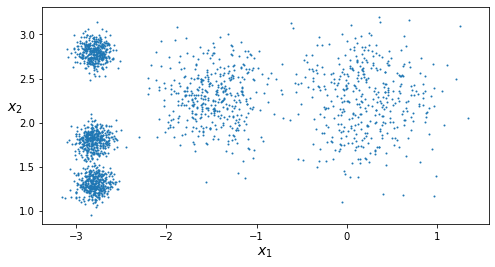

In [5]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [6]:
# train a K-Means clusterer
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

print(f"y_pred assigned clusters = {kmeans.labels_}")
print(f"Cluster centers = \n {kmeans.cluster_centers_}")

y_pred assigned clusters = [0 4 1 ... 2 1 4]
Cluster centers = 
 [[-2.80037642  1.30082566]
 [ 0.20876306  2.25551336]
 [-2.79290307  2.79641063]
 [-1.46679593  2.28585348]
 [-2.80389616  1.80117999]]


In [7]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

If the cluster's decision boundaries are plotted, we get a *Voronoi tesselation*.

In [8]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

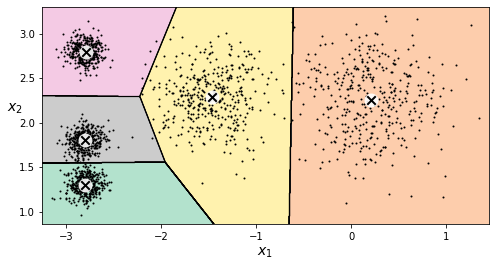

In [9]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Can see above that some samples are incorrectly classified. Instead of *hard clustering*, where a sample is assigned to one class, we can use *soft clustering* and jsut give each sample a score instead.

In [10]:
# e.g. distance to a cluster is a score
kmeans.transform(X_new) # return distance to each cluster center

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

This is a method to transform data with high feature dimension to a lower *k* dimensional data for *k* is the number of clusters.

### Centroid Initialization Methods

K-Means is sensitive to initialization. Since the algorithm is random and it converges within finite time, a bad initialization can cause it to end up with a non-optimal solution.

Solutions:

1. If you happen know where the centroid centers might approximatley be, use the `init` param of the `KMeans` class.
2. Run for a finite number of times with different random initializations and keep the best KMeans model based on the performance metric *inertia* (mean squared distance between each instance and its closest centorid).

In [11]:
print(f"KMeans intertia = {kmeans.inertia_}")

# can also be accessed by score function
print(f"KMeans intertia = {kmeans.score(X)}")

KMeans intertia = 211.59853725816836
KMeans intertia = -211.5985372581684


Score output is negative because the `score()` function MUST respect *greater is better* rule.

### K-Means Improvements

These methods below are what `sklearn`'s `Kmeans` class uses.

#### *K-Means+/\+*

This initialization method is a smarter instantiation method that tends to select centroids further from one another --> less likely to converge to sub-optimal solution.

#### *Accelerated K-means and Mini-batch K-Means*

Avoids many unnecessary distance calculations by:
1. Exploiting triangle inequality
2. Keeping track of upper and lower bounds for distances between instances and centroids

K-Means is also capable of using mini-batches, moving centroids just slightly at each iteration.

In [12]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

### Finding Optimal Number of Clusters

In [13]:
# plot inertia as a function of clusters
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

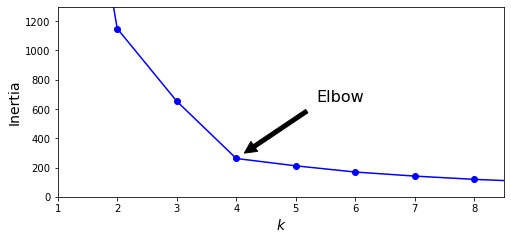

In [14]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

The elbow is a coarse method to approximate where an approximate number of clusters can be. 

A better (but computationally more expensive metric is the *silhouette score*). For every instance, this metric will return a score between -1 and +1 (with -1 being potentially wrongly classified and +1 as being very close to the center of the cluster). See the textbook for the eqn.

In [15]:
from sklearn.metrics import silhouette_score
print(f"Silhouette Score = {silhouette_score(X, kmeans.labels_)}")

Silhouette Score = 0.655517642572828


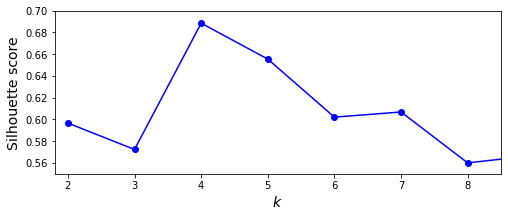

In [16]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Can see that this is much richer in info. Not only is $k=4$ good but $k=5$ is not too shabby as well.

### Clustering for Preprocessing

Can be an efficient approach to dimensionality reduction.

In [17]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [19]:
# fit a baseline logistic regression model
from sklearn.linear_model import LogisticRegression

# need to set multi_class param
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", 
                                max_iter=5000, random_state=42) 
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test) # accuracy

0.9688888888888889

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

kmeans_pip = Pipeline([ 
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])

kmeans_pip.fit(X_train, y_train)
kmeans_pip.score(X_test, y_test)

0.9777777777777777

Can see from K-means preprocessing, the error rate dropped by around 30%.

Since $k$ is just a hyperparam in the context of the classification pipeline, run a cross-validation sweep to find the best number of clusters.

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=list(np.linspace(10, 100, 10, dtype=int)))
grid_clf = GridSearchCV(kmeans_pip, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

/var/folders/sh/1qclfzm54zlgld8yp8_l0bbh0000gn/T/ipykernel_34967/451313774.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  param_grid = dict(kmeans__n_clusters=list(np.linspace(10, 100, 10, dtype=np.int)))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..............................kmeans__n_clusters=10; total time=   0.9s
[CV] END ..............................kmeans__n_clusters=10; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=10; total time=   0.3s
[CV] END ..............................kmeans__n_clusters=20; total time=   4.3s
[CV] END ..............................kmeans__n_clusters=20; total time=   5.0s
[CV] END ..............................kmeans__n_clusters=20; total time=   4.4s
[CV] END ..............................kmeans__n_clusters=30; total time=   4.9s
[CV] END ..............................kmeans__n_clusters=30; total time=   4.8s
[CV] END ..............................kmeans__n_clusters=30; total time=   5.1s
[CV] END ..............................kmeans__n_clusters=40; total time=   6.3s
[CV] END ..............................kmeans__n_clusters=40; total time=   6.5s
[CV] END ..............................kmeans__n

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': [10, 20, 30, 40, 50, 60, 70, 80,
                                                90, 100]},
             verbose=2)

In [24]:
print(grid_clf.best_params_)
print(grid_clf.score(X_test, y_test)) # see error rate dropped a little bit more

{'kmeans__n_clusters': 80}
0.98


### Clustering for Semi-supervised Learning

In [27]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test) # acc won't be as high since trained on less labeled data

0.8333333333333334

In [30]:
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
dist_to_digits = kmeans.fit_transform(X_train)

In [32]:
digits_closest_to_centroid_idx = np.argmin(dist_to_digits, axis=0)
digits_closest_to_centroid = X_train[digits_closest_to_centroid_idx]

In [33]:
# "manually" label each instance
y_digits = y_train[digits_closest_to_centroid_idx]

In [36]:
# train on the cluster type now
log_reg = LogisticRegression(max_iter=5000, multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(digits_closest_to_centroid, y_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

See! Much higher evaluation accuracy now! It is important to label representative instances rather than just random instances. That is why we picked the cluster center.

We can go one step further and label all of the cluster instances as well. This is called *label propogation*.

In [37]:
y_train_propogated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propogated[kmeans.labels_ == i] = y_digits[i]

In [38]:
# train logistic regression again and see how much performance increase is obtained
log_reg = LogisticRegression(max_iter=5000, multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train_propogated)
log_reg.score(X_test, y_test)

0.9333333333333333

We got about a ~1% increase in performance. We could get better performance if the instances close to the cluster borders are not labeled, since these can very often be mislabeled. Let's just label 20% of the cluster instances.

In [44]:
percentile_closest = 20

# instantiate an array and set idx i equal to dist_to_digits[i, cluster_label_idx]
X_cluster_dist = dist_to_digits[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_dist)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propogated = (X_cluster_dist != -1)
X_train_partial_prop = X_train[partially_propogated]
y_train_partial_prop = y_train[partially_propogated]


In [45]:
log_reg = LogisticRegression(max_iter=5000, multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train_partial_prop, y_train_partial_prop)
log_reg.score(X_test, y_test)

0.9466666666666667

With on average 5 instances per cluster, we achieved a ~95% accuracy! This is only 2% less than the performance of a logisitc regression on the fully labeled dataset.

### DBSCAN

Another clustering algorithm that works well with irregularly shaped clusters. Works by focusing on looking for dense regions with $\epsilon$-neighbors (core instances) and then chaining sequences of such cores together to form a cluster.

Don't need to know/guess a pre-defined number of clusters.

In [52]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

When a cluster index has value -1, it means thast DBSCAN has labelled the instance an anomaly.

In [62]:
# print out the indices of the first 10 core samples
print(dbscan.core_sample_indices_[:10])
# print their coordinates
print(dbscan.components_[:10])
# print their labels
print(dbscan.labels_[:10])

[ 0  4  5  6  7  8 10 11 12 13]
[[-0.02137124  0.40618608]
 [-0.84192557  0.53058695]
 [ 0.58930337 -0.32137599]
 [ 0.29248724 -0.20696309]
 [-0.02637836  0.44766267]
 [ 1.6201408  -0.28758856]
 [ 1.26718285 -0.40793471]
 [ 0.87418608  0.50781041]
 [ 0.3322007  -0.19032202]
 [ 1.952812    0.22552333]]
[ 0  2 -1 -1  1  0  0  0  2  5]


In [57]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

In [58]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

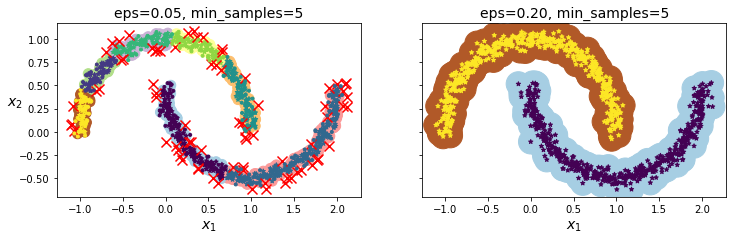

In [61]:
plt.figure(figsize=(12, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

DBSCAN does NOT have a `predict()` method, though it does have a `fit_predict()` method. The rationale for this is that it is easy enough to utilize another classification algorithm to do it on DBSCAN's behalf.

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X[dbscan2.core_sample_indices_], dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [71]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print(f"prediction = {knn.predict(X_new)}")
print(f"probability = \n {knn.predict_proba(X_new)}")

prediction = [1 0 1 0]
probability = 
 [[0.18 0.82]
 [1.   0.  ]
 [0.12 0.88]
 [1.   0.  ]]


KNN has no anamoly detection but it's simple to introduce a *max distance* to determine which samples are anomalies by using the `kneighbors()` function.

In [73]:
th = 0.2
neigh_dist, neigh_idx = knn.kneighbors(X_new, n_neighbors=1)
neighbor_labels = dbscan2.labels_[dbscan2.core_sample_indices_][neigh_idx]
neighbor_labels[neigh_dist > th] = -1
neighbor_labels.ravel()

array([-1,  0,  1, -1])

## Gaussian Mixtures

In [74]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [79]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, n_init=10) # n_init for how many times to run
                                                 # so that algo can converge
gmm.fit(X)

print("weights = ", gmm.weights_)
print("means = \n", gmm.means_)
print("covariances = \n", gmm.covariances_)

print(f"converged? {gmm.converged_}")
print(f"n_iters = {gmm.n_iter_}")

weights =  [0.3902064  0.20970929 0.40008431]
means = 
 [[ 0.0512132   0.07512971]
 [ 3.39854326  1.05926051]
 [-1.4076241   1.42704927]]
covariances = 
 [[[ 0.68780591  0.79597839]
  [ 0.79597839  1.21232694]]

 [[ 1.14901133 -0.03241901]
  [-0.03241901  0.95484861]]

 [[ 0.63480459  0.72971575]
  [ 0.72971575  1.16110086]]]
converged? True
n_iters = 4


In [81]:
# hard clustering
print(gmm.predict(X))
# soft clustering
print(gmm.predict_proba(X)) # probability for each cluster

[0 0 2 ... 1 1 1]
[[9.76688618e-01 2.33107018e-02 6.80230786e-07]
 [9.82774531e-01 1.65481663e-02 6.77302883e-04]
 [7.42085667e-05 2.04358925e-06 9.99923748e-01]
 ...
 [4.21582331e-07 9.99999578e-01 2.17682412e-26]
 [4.93027253e-16 1.00000000e+00 1.50345348e-41]
 [2.19825399e-15 1.00000000e+00 8.24833927e-41]]


In [82]:
# also possible to sample instances since GMM is a generative model
X_new, y_new = gmm.sample(6)
for coord, label in zip(X_new, y_new):
    print(f"{coord} : {label}")

[-1.07495472 -0.70200827] : 0
[0.12732458 0.29184889] : 0
[0.70964291 0.40607779] : 0
[2.20254521 1.34215876] : 1
[2.67534189 1.15305144] : 1
[4.73960922 0.31437973] : 1


In [83]:
# also possible to estimate the density of the model at any given location
gmm.score_samples(X)

array([-2.60753797, -3.57117632, -3.32962239, ..., -3.51337454,
       -4.39800533, -3.80760349])

In [85]:
# take the exponential to get the PDF values (probability density function) for each instance
pdf_val = np.exp(gmm.score_samples(X))
print(pdf_val)

[0.07371581 0.02812275 0.03580662 ... 0.0297962  0.01230185 0.02220132]


In [86]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

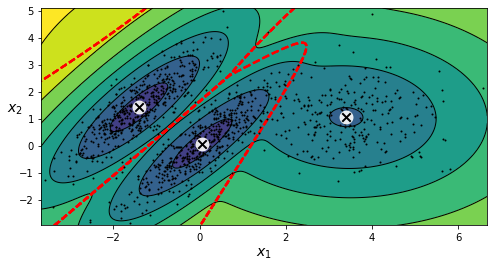

In [87]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gmm, X)
plt.show()

### Anomaly Detection using Gaussian Mixtures

Very easy to perform anomaly detection using GMMs --> if an instance lies in a low density region, it is most likely an outlier. It will be up to the engineer to set what this threshold should be.

In [90]:
percentile = 4

densities = gmm.score_samples(X)
density_th = np.percentile(densities, percentile)
anomalies = X[densities < density_th]
print(anomalies[:10])

[[-0.11118987  1.61334992]
 [ 0.62362922  4.41540435]
 [ 1.49808977 -0.15251688]
 [ 0.74219223 -1.00445177]
 [-2.53940854 -2.76549965]
 [-1.62447969 -0.45770022]
 [-1.74680316 -0.78385111]
 [-3.58308316 -1.28249917]
 [ 0.53903026  5.00244257]
 [-0.51480414 -2.16270124]]


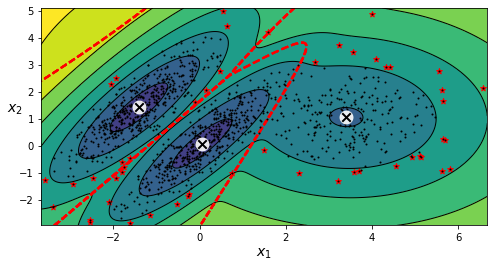

In [91]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gmm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

### Selecting Number of Clusters

Just like K-Means, GMM requires a predefined number of clusters. Common measures for GMM are: 

1. BIC (*Bayesian Information Criterion*) = $log(m)p - 2log(\hat{L})$
2. AIC (*Akaike Information Criterion*) = $2p - 2log(\hat{L})$

The aim if the *minimize* one of the metrics (both very similar so does not matter too much).

Here, $m$ = num instances, $p$ = num params learned by model, and $\hat{L}$ = maximized value of likelihood function.

In [92]:
print(f"BIC = {gmm.bic(X)}")
print(f"AIC = {gmm.aic(X)}")

BIC = 8189.756836104974
AIC = 8102.531555989936


In [95]:
# compute the BIC and AIC manually as well
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gmm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [96]:
gmms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [97]:
bics = [model.bic(X) for model in gmms_per_k]
aics = [model.aic(X) for model in gmms_per_k]

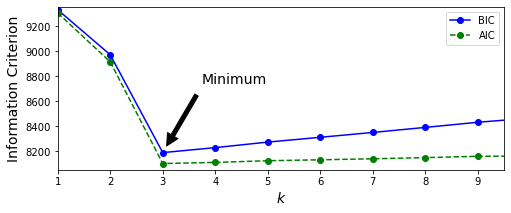

In [98]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

### Bayesian GMM

`BayesianGaussianMixture` class is able to automatically eliminate unncessary clusters by setting the weights equal or close to 0. Just set the param `n_components` to a value reasonable for the problem at hand.

In [99]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])